# Importing necessary libraries

In [1]:
%pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4xjnwz7l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4xjnwz7l
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import torchvision
from torchvision.datasets.flowers102 import Flowers102
import torch.nn.functional as F
from tqdm import tqdm
from torch import nn, optim
import clip
import random
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

## Utility Functions

In [3]:
def base_novel_categories(dataset) -> tuple[list[int], list[int]]:
    # set returns the unique set of all dataset classes
    all_classes = set(dataset._labels)
    # and let's count them
    num_classes = len(all_classes)

    # here list(range(num_classes)) returns a list from 0 to num_classes - 1
    # then we slice the list in half and generate base and novel category lists
    base_classes = list(range(num_classes))[:num_classes // 2]
    novel_classes = list(range(num_classes))[num_classes // 2:]
    return base_classes, novel_classes


def harmonic_mean(base_accuracy, novel_accuracy):
    numerator = 2
    denominator = 1 / base_accuracy + 1 / novel_accuracy
    hm = numerator / denominator
    return hm


def get_data(data_dir='./data', transform=None) -> tuple[Flowers102,
                                                         Flowers102,
                                                         Flowers102]:
    """Load Flowers102 train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    train = torchvision.datasets.Flowers102(
        root=data_dir, split="train", download=True, transform=transform)
    val = torchvision.datasets.Flowers102(
        root=data_dir, split="val", download=True, transform=transform)
    test = torchvision.datasets.Flowers102(
        root=data_dir, split="test", download=True, transform=transform)
    return train, val, test


def split_data(dataset, base_classes):
    # these two lists will store the sample indexes
    base_categories_samples = []
    novel_categories_samples = []

    # we create a set of base classes to compute the test below in O(1)
    # this is optional and can be removed
    base_set = set(base_classes)

    # here we iterate over sample labels and also get the correspondent sample index
    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)

    # here we create the dataset subsets
    # the torch Subset is just a wrapper around the dataset
    # it simply stores the subset indexes and the original dataset (your_subset.dataset)
    # when asking for sample i in the subset, torch will look for its original position in the dataset and retrieve it
    # https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset

def accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

def train_one_epoch(model, dataloader, optimizer, base_indices):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logits = model(images) # shape: [B, 102]

        # compute loss only on base classes
        logits_base = logits[ : , base_indices] # shape: [B, 51]

        loss = F.cross_entropy(logits_base, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy(logits_base, labels)

    return total_loss / len(dataloader), total_acc / len(dataloader)

@torch.no_grad()
def eval(model, dataloader):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logits = model(images)
        loss = F.cross_entropy(logits, labels)

        total_loss += loss.item()
        total_acc += accuracy(logits, labels)

    return total_loss / len(dataloader), total_acc / len(dataloader)

def train_loop(model, train_loader, val_loader, optimizer, base_indices, epochs=10):
    history = { "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [] }

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch: {epoch}/{epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, base_indices)
        val_loss, val_acc = eval(model, val_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc.: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc.: {val_acc:.4f}")

    return history


# -- Reproducibility utils --

def set_seed(seed: int = 42):
  """
  Settings used for reproducibility purposes.
  https://pytorch.org/docs/stable/notes/randomness.html
  """
  # Python & NumPy
  random.seed(seed)
  np.random.seed(seed)

  # Torch
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  # Torch determinism
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  print(f"[INFO] Seed set to {seed}")


def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


# Model Definition

### CLIP-Adapter

In [4]:
class Adapter(nn.Module):
    def __init__(self, c_in, reduction=4):
        super(Adapter, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=c_in, out_features=c_in // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=c_in // reduction, out_features=c_in, bias=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

### Custom CLIP

In [5]:
class TextEncoder(nn.Module):
    def __init__(self, classnames, clip_model):
        super().__init__()
        self.classnames = classnames
        self.clip_model = clip_model
        self.dtype = clip_model.dtype

    def forward(self):
        temp = 'a photo of a {}, a type of flower.'
        prompts = [temp.format(classname) for classname in self.classnames]
        prompts = torch.cat([clip.tokenize(p) for p in prompts])
        prompts = prompts.to(DEVICE)
        text_features = self.clip_model.encode_text(prompts)
        return text_features

class CustomCLIP(nn.Module):
    def __init__(
        self,
        classnames: list[str],
        clip_model: nn.Module,
        adapter_ratio: float = 0.2,
    ):
        super().__init__()
        self.classnames = classnames
        self.clip_model = clip_model
        self.dtype = clip_model.dtype
        self.logit_scale = clip_model.logit_scale
        self.adapter_ratio = adapter_ratio

        # encoders
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(classnames, clip_model)

        embed_dim = clip_model.visual.output_dim
        self.adapter = Adapter(c_in=embed_dim, reduction=4)

    def forward(self, images: torch.Tensor, return_features=False):
        # encode images
        original_features = self.image_encoder(images.type(self.dtype))
        adapted = self.adapter(original_features.float()).type(self.dtype) # Cast to float for adapter, then back to original dtype

        # combine original image features with output from the adapter
        combined = self.adapter_ratio * adapted + (1 - self.adapter_ratio) * original_features

        # normalize
        original_features_norm = original_features / original_features.norm(dim=-1, keepdim=True)
        image_features_norm = combined / combined.norm(dim=-1, keepdim=True)

        if return_features:
            return image_features_norm, original_features_norm

        # ecoding text features
        text_features = self.text_encoder()
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # compute logits
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features_norm @ text_features.t()

        return logits

# Preparing the Dataset and CLIP

In [6]:
set_seed(SEED)

# Inspect classes
_, _, tmp_test = get_data()
base_classes, novel_classes = base_novel_categories(tmp_test)

CLASS_NAMES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
    'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
    'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
    'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
    'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly',
    'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose',
    'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue',
    'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium',
    'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
    'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy',
    'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy',
    'gazania', 'azalea', 'water lily', 'rose', 'thorn apple',
    'morning glory', 'passion flower', 'lotus lotus', 'toad lily', 'anthurium',
    'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose',
    'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily',
    'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea',
    'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
    'trumpet creeper', 'blackberry lily'
]

# available models = ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
clip_model, preprocess = clip.load("ViT-B/16", device=DEVICE)

# get the three datasets
train_set, val_set, test_set = get_data(transform=preprocess)

# split classes into base and novel
base_classes, novel_classes = base_novel_categories(train_set)

# split the three datasets
train_base, _ = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)

# Create data loaders
g = torch.Generator()
g.manual_seed(SEED)

train_loader = torch.utils.data.DataLoader(
    train_base,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker
)
val_loader = torch.utils.data.DataLoader(
    val_base,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    generator=g,
    worker_init_fn=seed_worker
)

[INFO] Seed set to 42


# Preparing the custom Model + Training

In [7]:
# hyperparameters
epochs = 20
adapter_ratio = 0.2

model = CustomCLIP(
    CLASS_NAMES,
    clip_model,
    adapter_ratio=adapter_ratio,
).to(DEVICE)

optimizer = optim.AdamW(model.adapter.parameters(), lr=2e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

history = train_loop(model, train_loader, val_loader, optimizer, epochs=epochs, base_indices=base_classes)


Epoch: 1/20


Train Loss: 1.0869 | Train Acc.: 0.6921
Val Loss: 1.0795 | Val Acc.: 0.7124

Epoch: 2/20


Train Loss: 0.7435 | Train Acc.: 0.8039
Val Loss: 0.8537 | Val Acc.: 0.7633

Epoch: 3/20


Train Loss: 0.5340 | Train Acc.: 0.8549
Val Loss: 0.6605 | Val Acc.: 0.8201

Epoch: 4/20


Train Loss: 0.3332 | Train Acc.: 0.9374
Val Loss: 0.5504 | Val Acc.: 0.8747

Epoch: 5/20


Train Loss: 0.2248 | Train Acc.: 0.9764
Val Loss: 0.4693 | Val Acc.: 0.8824

Epoch: 6/20


Train Loss: 0.1589 | Train Acc.: 0.9844
Val Loss: 0.4128 | Val Acc.: 0.9022

Epoch: 7/20


Train Loss: 0.1152 | Train Acc.: 0.9922
Val Loss: 0.3933 | Val Acc.: 0.9121

Epoch: 8/20


Train Loss: 0.0833 | Train Acc.: 1.0000
Val Loss: 0.3538 | Val Acc.: 0.9215

Epoch: 9/20


Train Loss: 0.0670 | Train Acc.: 1.0000
Val Loss: 0.3172 | Val Acc.: 0.9353

Epoch: 10/20


Train Loss: 0.0519 | Train Acc.: 1.0000
Val Loss: 0.3285 | Val Acc.: 0.9277

Epoch: 11/20


Train Loss: 0.0426 | Train Acc.: 1.0000
Val Loss: 0.2923 | Val Acc.: 0.9374

Epoch: 12/20


Train Loss: 0.0331 | Train Acc.: 1.0000
Val Loss: 0.2850 | Val Acc.: 0.9432

Epoch: 13/20


Train Loss: 0.0286 | Train Acc.: 1.0000
Val Loss: 0.2873 | Val Acc.: 0.9413

Epoch: 14/20


Train Loss: 0.0246 | Train Acc.: 1.0000
Val Loss: 0.2647 | Val Acc.: 0.9471

Epoch: 15/20


Train Loss: 0.0214 | Train Acc.: 1.0000
Val Loss: 0.2613 | Val Acc.: 0.9452

Epoch: 16/20


Train Loss: 0.0187 | Train Acc.: 1.0000
Val Loss: 0.2541 | Val Acc.: 0.9491

Epoch: 17/20


Train Loss: 0.0170 | Train Acc.: 1.0000
Val Loss: 0.2455 | Val Acc.: 0.9530

Epoch: 18/20


Train Loss: 0.0152 | Train Acc.: 1.0000
Val Loss: 0.2443 | Val Acc.: 0.9471

Epoch: 19/20


Train Loss: 0.0134 | Train Acc.: 1.0000
Val Loss: 0.2390 | Val Acc.: 0.9569

Epoch: 20/20


Train Loss: 0.0122 | Train Acc.: 1.0000
Val Loss: 0.2374 | Val Acc.: 0.9510


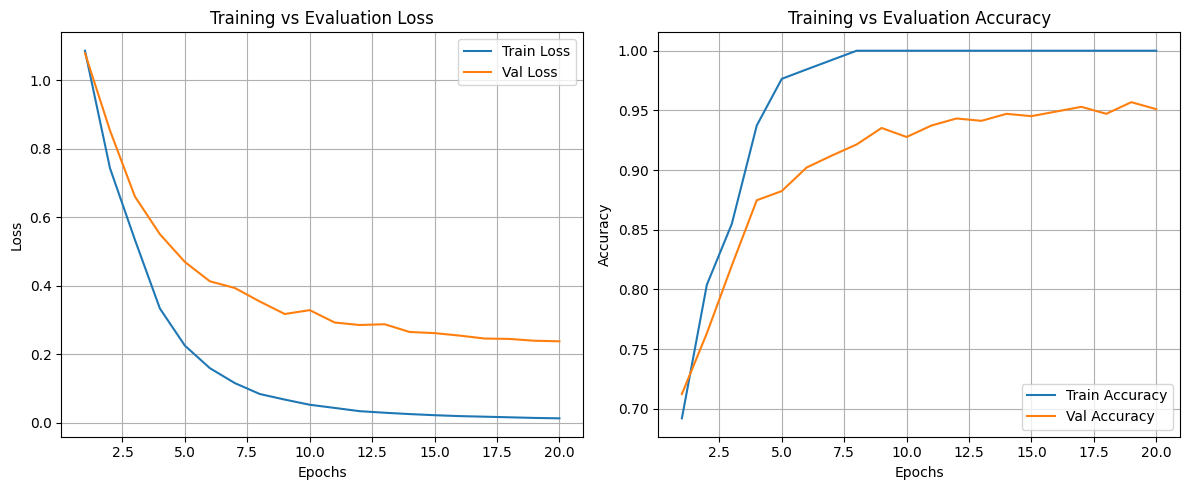

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Used as reference for plotting on the x-axis
x = range(1, epochs + 1)

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(x, history['train_loss'], label='Train Loss')
plt.plot(x, history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(x, history['train_acc'], label='Train Accuracy')
plt.plot(x, history['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training vs Evaluation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation

In [9]:
# ---- Compute accuracy on base and novel classes ----
baseLoader = torch.utils.data.DataLoader(
    test_base,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)
novelLoader = torch.utils.data.DataLoader(
    test_novel,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)

print()
_, base_accuracy = eval(model, baseLoader)
print(f"🔍 Base classes accuracy: {base_accuracy*100:.2f}%")
_, novel_accuracy = eval(model, novelLoader)
print(f"🔍 Novel classes accuracy: {novel_accuracy*100:.2f}%")
print(f"🔍 Harmonic Mean: {harmonic_mean(base_accuracy, novel_accuracy)*100:.2f}%")


🔍 Base classes accuracy: 93.53%


🔍 Novel classes accuracy: 61.69%
🔍 Harmonic Mean: 74.34%


# CLIP-Adapter Analysis
The following code tries to assess how CLIP-Adapter's adapted features diverge from the original CLIP features and how that correlates with the performance of the model on both base and novel classes.

In [10]:
def extract_features_and_metrics(model, dataloader, base_indices):
    model.eval()
    results = []
    base_set = set(base_indices)
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Analyzing", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            # Get features
            adapted_feats, original_feats = model(images, return_features=True)
            
            # Calculate metric (cosine sim.)
            cosine_sim = (adapted_feats * original_feats).sum(dim=1)
            
            # compute accuracy
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            correct = (preds == labels)
            
            for i in range(len(labels)):
                label_item = labels[i].item()
                is_base = label_item in base_set
                
                results.append({
                    'cosine_sim': cosine_sim[i].item(),
                    'is_correct': correct[i].item(),
                    'is_base': is_base,
                    'label': label_item
                })
                
    return results

In [11]:
# Run analysis on Test Set (combining base and novel for full picture, or separate)
# We have test_base and test_novel datasets. Let's combine them or iterate both.

full_test_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([test_base, test_novel]),
    batch_size=128,
    shuffle=False,
    num_workers=2,
    generator=g
)

results = extract_features_and_metrics(model, full_test_loader, base_classes)

In [12]:
import pandas as pd
df = pd.DataFrame(results)
df.head()

,cosine_sim,is_correct,is_base,label
0,0.849121,True,True,0
1,0.834473,True,True,0
2,0.842285,True,True,0
3,0.794434,True,True,0
4,0.839844,True,True,0


/tmp/ipython-input-3541373355.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['sim_bin', 'is_base'])['is_correct'].mean().unstack()
/tmp/ipython-input-3541373355.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['sim_bin', 'is_base'])['is_correct'].count().unstack()


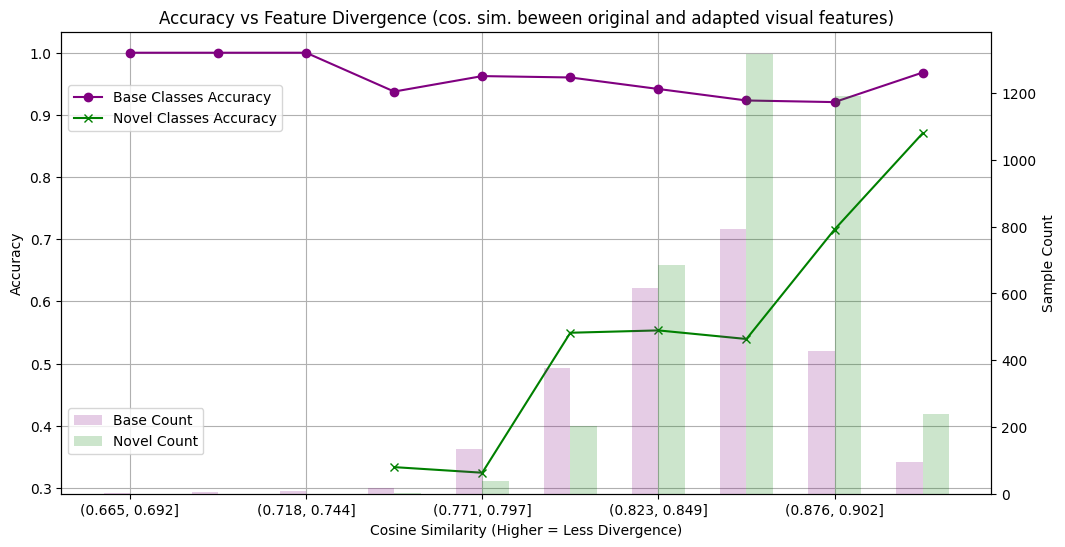

In [35]:
def analyze_and_plot(df):
    # Binning cosine similarity
    # High cosine sim -> low divergence between non-adapted and adapter visual features
    # Low cosine sim -> high divergence between non-adapted and adapter visual features
    
    df['sim_bin'] = pd.cut(df['cosine_sim'], bins=10)
    
    # Group by bin and type (Base/Novel)
    grouped = df.groupby(['sim_bin', 'is_base'])['is_correct'].mean().unstack()
    counts = df.groupby(['sim_bin', 'is_base'])['is_correct'].count().unstack()
    
    # Plot Accuracy vs Cosine Similarity
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    grouped[True].plot(kind='line', marker='o', ax=ax1, label='Base Classes Accuracy', color='purple')
    grouped[False].plot(kind='line', marker='x', ax=ax1, label='Novel Classes Accuracy', color='green')
    
    ax1.set_title('Accuracy vs Feature Divergence (cos. sim. beween original and adapted visual features)')
    ax1.set_xlabel('Cosine Similarity (Higher = Less Divergence)')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.90)) # Moved slightly down
    ax1.grid(True)

    # Add bar plot for sample counts on secondary y-axis
    ax2 = ax1.twinx()
    width = 0.3
    x = np.arange(len(grouped.index))
    ax2.bar(x - width/2, counts[True], width=width, alpha=0.2, color='purple', label='Base Count')
    ax2.bar(x + width/2, counts[False], width=width, alpha=0.2, color='green', label='Novel Count')
    ax2.set_ylabel('Sample Count')
    ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.2))

analyze_and_plot(df)